**PART 4 - DSIM project**

Francesca De Cola, Valentina Moretto, Valentina Zangirolami

In this notebook, we focus on neural network. In particular, we have used fine tuning techniques.

**Load packages**

In [ ]:
import numpy as np
import glob
from PIL import Image
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2 as cv

from sklearn.utils import class_weight
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from sklearn.preprocessing import LabelEncoder
from keras_vggface import utils
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, StratifiedKFold

from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import keras

import tensorflow as tf
import random
import pickle
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
import random as rnd

Using TensorFlow backend.
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

**Seed for reproducibility**

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)

**Load dataset of images**

(We create this npz file in 1_creation_dataset.ipynb)

In [ ]:
data=np.load("C:/Users/valen/Desktop/magistrale/DSIM/dataset_imgs.npz")
label=data['Y']
img=data['X']

In [ ]:
le = LabelEncoder()
label=le.fit_transform(label)

This last passage is necessary to transform label to (0,6) classes. 

**Train-Validation-Test**

In this section, we divide dataset in train - validation - test for evaluate neural network.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img, label, test_size = .2, random_state = SEED, stratify = label)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = SEED, stratify = y_train)

In [ ]:
y_test_eff=y_test
y_train=to_categorical(y_train, num_classes=7)
y_val=to_categorical(y_val, num_classes=7)
y_test=to_categorical(y_test, num_classes=7)

Shape for each partition:

In [ ]:
x_train.shape, x_val.shape, x_test.shape

((1452, 224, 224, 3), (363, 224, 224, 3), (454, 224, 224, 3))

**Data augmentation**

Data augmentation is a technique used to augmented the data and to increment the variation of them. In this case, this method is more useful because the size of training set is very poor. 

This choice allows us to generalization results (avoid overfitting) and to obtain more consistent result (based on more data).

The specification of data augmentation are:

* rotation of image with a grade of degree for random rotation equal to 25
* variation of brightness into a range (0.5, 1.5), this specification allows to lighten and darken images
* shift of images respect on width and height with a fraction equal to 0.3
* horizontal flip
* Random zoom into a range (0.8, 1.2)

We used to preprocess images the function of preprocessing of vggface, this operation can increase performance because our images are treated such as images of vggface and help pretrained neural network to manage new images.

Data augmentation is applied only on training set, validation and test set contain only the function to preprocess images.

In [ ]:
def train_loader(preproc_function, img, label):
    train_gen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= preproc_function,
                                                                rotation_range=25,
                                                                brightness_range=(0.5,1.5),
                                                                width_shift_range=.3,
                                                                height_shift_range=.3,
                                                                horizontal_flip=True,
                                                                zoom_range=.2)
    train_generator=train_gen.flow(x=img, y=label, batch_size=32, seed=SEED)
    return train_generator
def test_loader(preproc_function, img, label):
    test_gen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= preproc_function)
    test_generator=test_gen.flow(x=img, y=label, batch_size=32,  seed=SEED)
    return test_generator

In [ ]:
train_generator=train_loader(utils.preprocess_input, x_train, y_train)
val_generator=test_loader(utils.preprocess_input, x_val, y_val)
test_generator=test_loader(utils.preprocess_input, x_test, y_test)

Follow step is useful only for predict phase. 

In [ ]:
x_test=x_test.astype('float64')
x_test = utils.preprocess_input(x_test,version=2)

**VGGFACE - FINE TUNING**

At first, we create a function *create_base_model* to load VGGFace model and include the operation to render trainable layers from a certain point on.

In [ ]:
def create_base_model(name_layer_stop):
    base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')

    for layer in base_model.layers:
        if layer.name == name_layer_stop:
            break
        else:
            layer.trainable = False
  
    return base_model

We define the structure fully-connected to added at vggface, with a combination of layers dense and dropout. We choice to unfreeze weights of pretrained network at layer *conv5_1_1x1_reduce* (the structure of vggface is visible in the Classifier.ipynb), that can be allows to use weighs pretrained with the task use to train vggface.

Dropout layer allows to avoid overfitting because inhibits randomly input units with a frequency equal to the number specify (in this first case is equal to 0.5).

We use adam optimezer with a low value of learning rate (guarantee more stable estimates) and specify accuracy metric to evaluate model.

Also, we define three types of callbacks:
* ModelCheckpoint, that allows to save the best weights in correspondence to minimum value of validation loss
* EarlyStopping, that allows to avoid overfitting and to achieve convergence of alghoritm. It used to stop the train phase when validation loss increas for 6 epochs
* ReduceLROnPlateau, it is used to scalar a value of learning rate (in this case: $new\_lr=0.5*lr$) when validation loss increases for 3 epochs

We specify steps_per_epoch, validation_steps and steps (on evaluation phase) with $steps= \frac{number\_of\_images}{batch\_size}$ (batch_size=32 and number of images refers to number of images for each partition)

In [ ]:
base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics = ['acc'])
   

filepath = "C:/Users/valen/Desktop/magistrale/DSIM/aml/weights-tmp1.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early= EarlyStopping(monitor='val_loss', patience= 6, mode='min', verbose=1)
lr_decay=ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

history_vggface = model.fit_generator(train_generator, epochs = 100, validation_data = val_generator,
                              verbose = 1, callbacks = [checkpoint, early, lr_decay], steps_per_epoch=45, validation_steps=11)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
45/45 [==============================] - 99s 2s/step - loss: 3.2362 - acc: 0.2007 - val_loss: 2.6631 - val_acc: 0.3352
Epoch 2/100
45/45 [==============================] - 93s 2s/step - loss: 1.9907 - acc: 0.2058 - val_loss: 1.4969 - val_acc: 0.4169
Epoch 3/100
45/45 [==============================] - 93s 2s/step - loss: 1.7895 - acc: 0.3012 - val_loss: 1.4861 - val_acc: 0.4109
Epoch 4/100
45/45 [==============================] - 93s 2s/step - loss: 1.5481 - acc: 0.4049 - val_loss: 0.9557 - val_acc: 0.7492
Epoch 5/100
45/45 [==============================] - 93s 2s/step - loss: 1.3197 - acc: 0.5307 - val_loss: 0.7111 - val_acc: 0.7946
Epoch 6/100
45/45 [==============================] - 93s 2s/step - loss: 1.0858 - acc: 0.6178 - val_loss: 0.4051 - val_acc: 0.8

After train-validation phase, we test this network on test data to test performance.

In [ ]:
model.load_weights(filepath)
score = model.evaluate_generator(test_generator, verbose=1, steps=14)
accuracy = 100*score[1]
loss = score[0]
print("Test accuracy: {} %".format(round(accuracy, 3)))
print("Test loss: {}".format(round(loss, 4)))

14/14 [==============================] - 20s 1s/step
Test accuracy: 88.393 %
Test loss: 0.4521


Result are very confortable, we try to improve performance increasing complexity but adding, also, weight and bias regularization. Weight regularization can help to balance the trade off bias-variance when model's complexity increase.

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        64
           1       0.92      0.75      0.83        60
           2       0.93      0.83      0.87        63
           3       0.98      0.95      0.97        64
           4       0.94      0.91      0.93        69
           5       0.88      0.89      0.88        73
           6       0.76      0.93      0.84        61

    accuracy                           0.89       454
   macro avg       0.89      0.88      0.88       454
weighted avg       0.89      0.89      0.89       454

Confusion matrix:
[[59  3  0  0  0  2  0]
 [10 45  0  1  0  3  1]
 [ 0  0 52  0  0  2  9]
 [ 1  0  0 61  0  0  2]
 [ 0  0  0  0 63  1  5]
 [ 1  1  2  0  3 65  1]
 [ 0  0  2  0  1  1 57]]


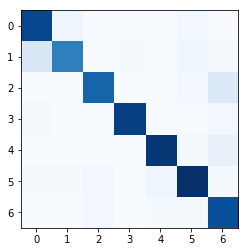

In [ ]:
y_pred=model.predict(x_test)
y_pred= np.argmax(y_pred, axis=1)

print('Classification report:')
print(classification_report(y_test_eff, y_pred))

print('Confusion matrix:')
cm=confusion_matrix(y_test_eff, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

We define a function *model_plot* to plot loss (training set and validation set) and accuracy(training set and validation set).

In [ ]:
def model_plot(model): 
    plt.figure(figsize=(15,7))
    ax1=plt.subplot(121)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.legend(['Training','Validation'])
    
    ax2=plt.subplot(122)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    ax2.plot(model.history['acc'])
    ax2.plot(model.history['val_acc'])
    ax2.legend(['Training','Validation'], loc='lower right')
    plt.show()

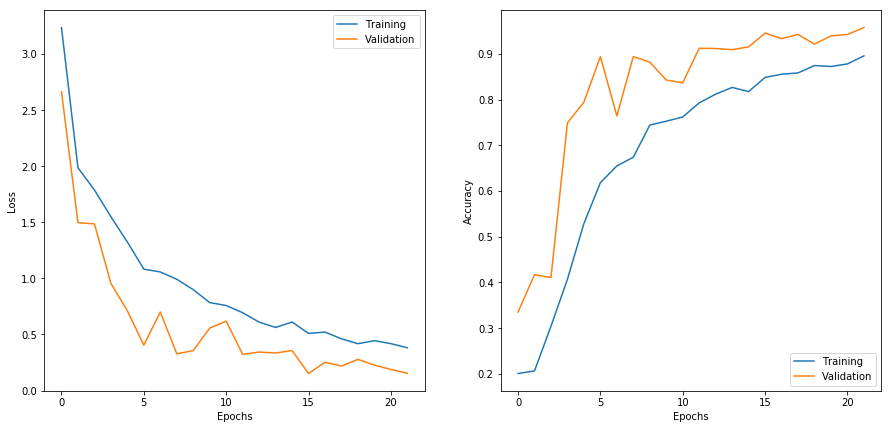

In [ ]:
model_plot(history_vggface)

In this two graph we note that loss and accuracy value are more stable in train phase, but in validation set are less stable. This effect diminishes as the epochs increase. Overall accuracy is 89%, but the value of f1 score are not very high for all classes excluding the third and fourth classes.

In the follow neural network, we added a bias regularizer that it is used to reduce bias of estimates.

In [ ]:
base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(512, activation = 'relu', bias_regularizer=regularizers.l1(0.01)))
model2.add(Dropout(.5))
model2.add(Dense(256, activation = 'relu',bias_regularizer=regularizers.l1(0.01)))
model2.add(Dropout(.5))
model2.add(Dense(128, activation = 'relu',bias_regularizer=regularizers.l1(0.01)))
model2.add(Dropout(.5))
model2.add(Dense(7, activation = 'softmax'))

model2.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics = ['acc'])
   

filepath = "C:/Users/valen/Desktop/magistrale/DSIM/aml/weights-tmp2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early= EarlyStopping(monitor='val_loss', patience= 6, mode='min', verbose=1)
lr_decay=ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

history_vggface2 = model2.fit_generator(train_generator, epochs = 100, validation_data = val_generator,
                              verbose = 1, callbacks = [checkpoint, early, lr_decay], steps_per_epoch=45, validation_steps=11)

Epoch 1/100
45/45 [==============================] - 98s 2s/step - loss: 3.4507 - acc: 0.1653 - val_loss: 2.6674 - val_acc: 0.1813
Epoch 2/100
45/45 [==============================] - 95s 2s/step - loss: 2.0362 - acc: 0.1734 - val_loss: 1.7723 - val_acc: 0.4375
Epoch 3/100
45/45 [==============================] - 96s 2s/step - loss: 1.8302 - acc: 0.2842 - val_loss: 1.5385 - val_acc: 0.5045
Epoch 4/100
45/45 [==============================] - 95s 2s/step - loss: 1.6565 - acc: 0.3603 - val_loss: 1.1981 - val_acc: 0.7190
Epoch 5/100
45/45 [==============================] - 94s 2s/step - loss: 1.5223 - acc: 0.4213 - val_loss: 0.9845 - val_acc: 0.7372
Epoch 6/100
45/45 [==============================] - 94s 2s/step - loss: 1.4561 - acc: 0.4630 - val_loss: 0.8185 - val_acc: 0.8187
Epoch 7/100
45/45 [==============================] - 94s 2s/step - loss: 1.2057 - acc: 0.5875 - val_loss: 0.7537 - val_acc: 0.7885
Epoch 8/100
45/45 [==============================] - 94s 2s/step - loss: 1.0907 - a

In [ ]:
model2.load_weights(filepath)
score = model2.evaluate_generator(test_generator, verbose=1, steps=14)
accuracy = 100*score[1]
loss = score[0]
print("Test accuracy: {} %".format(round(accuracy, 3)))
print("Test loss: {}".format(round(loss, 4)))

14/14 [==============================] - 19s 1s/step
Test accuracy: 88.152 %
Test loss: 0.4523


Classification report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        64
           1       0.85      0.88      0.87        60
           2       0.86      0.79      0.83        63
           3       0.97      0.97      0.97        64
           4       0.95      0.88      0.92        69
           5       0.92      0.81      0.86        73
           6       0.79      0.92      0.85        61

    accuracy                           0.88       454
   macro avg       0.88      0.88      0.88       454
weighted avg       0.89      0.88      0.88       454

Confusion matrix:
[[60  3  0  0  0  1  0]
 [ 7 53  0  0  0  0  0]
 [ 0  1 50  0  1  2  9]
 [ 0  1  0 62  0  0  1]
 [ 1  0  2  0 61  2  3]
 [ 3  3  5  0  1 59  2]
 [ 0  1  1  2  1  0 56]]


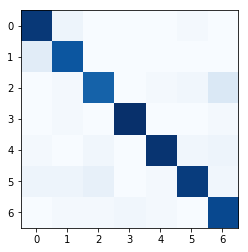

In [ ]:
y_pred2=model2.predict(x_test)
y_pred2= np.argmax(y_pred2, axis=1)

print('Classification report:')
print(classification_report(y_test_eff, y_pred2))

print('Confusion matrix:')
cm=confusion_matrix(y_test_eff, y_pred2)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

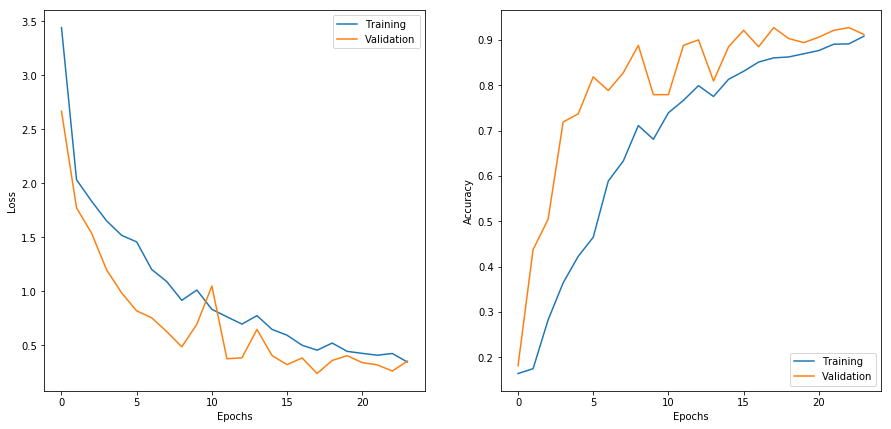

In [ ]:
model_plot(history_vggface2)

With the introduction of bias regularization, performance and stability decrease but it is possible to see that the difference of performance on training set and validation set are more similar that the previous case. We try to maintain this setting with and increase to complexity of the neural network with a larger number of nodes of second layer fully-connected.

In [ ]:
base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
model3 = Sequential()
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(512, activation = 'relu', bias_regularizer=regularizers.l1(0.01)))
model3.add(Dropout(.5))
model3.add(Dense(512, activation = 'relu',bias_regularizer=regularizers.l1(0.01)))
model3.add(Dropout(.5))
model3.add(Dense(128, activation = 'relu',bias_regularizer=regularizers.l1(0.01)))
model3.add(Dropout(.5))
model3.add(Dense(7, activation = 'softmax'))

model3.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics = ['acc'])
   

filepath = "C:/Users/valen/Desktop/magistrale/DSIM/aml/weights-tmp3.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early= EarlyStopping(monitor='val_loss', patience= 6, mode='min', verbose=1)
lr_decay=ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

history_vggface3 = model3.fit_generator(train_generator, epochs = 100, validation_data = val_generator,
                              verbose = 1, callbacks = [checkpoint, early, lr_decay], steps_per_epoch=45, validation_steps=11)

Epoch 1/100
45/45 [==============================] - 102s 2s/step - loss: 3.2404 - acc: 0.1667 - val_loss: 2.4206 - val_acc: 0.1790
Epoch 2/100
45/45 [==============================] - 97s 2s/step - loss: 2.2249 - acc: 0.1481 - val_loss: 1.9135 - val_acc: 0.2900
Epoch 3/100
45/45 [==============================] - 97s 2s/step - loss: 1.9672 - acc: 0.1947 - val_loss: 1.8851 - val_acc: 0.3293
Epoch 4/100
45/45 [==============================] - 97s 2s/step - loss: 1.8385 - acc: 0.2734 - val_loss: 1.6507 - val_acc: 0.5680
Epoch 5/100
45/45 [==============================] - 97s 2s/step - loss: 1.6184 - acc: 0.3755 - val_loss: 1.2841 - val_acc: 0.5891
Epoch 6/100
45/45 [==============================] - 97s 2s/step - loss: 1.3741 - acc: 0.4854 - val_loss: 0.9500 - val_acc: 0.7341
Epoch 7/100
45/45 [==============================] - 97s 2s/step - loss: 1.1918 - acc: 0.5774 - val_loss: 0.4477 - val_acc: 0.9033
Epoch 8/100
45/45 [==============================] - 97s 2s/step - loss: 1.0038 - 

In [ ]:
model3.load_weights(filepath)
score = model3.evaluate_generator(test_generator, verbose=1, steps=14)
accuracy = 100*score[1]
loss = score[0]
print("Test accuracy: {} %".format(round(accuracy, 3)))
print("Test loss: {}".format(round(loss, 4)))

14/14 [==============================] - 19s 1s/step
Test accuracy: 89.573 %
Test loss: 0.3439


Classification report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        64
           1       0.91      0.83      0.87        60
           2       0.88      0.89      0.88        63
           3       1.00      0.98      0.99        64
           4       0.89      0.93      0.91        69
           5       0.91      0.79      0.85        73
           6       0.90      0.93      0.92        61

    accuracy                           0.89       454
   macro avg       0.90      0.90      0.89       454
weighted avg       0.90      0.89      0.89       454

Confusion matrix:
[[58  3  0  0  0  3  0]
 [10 50  0  0  0  0  0]
 [ 1  0 56  0  1  0  5]
 [ 0  0  0 63  0  1  0]
 [ 0  0  3  0 64  2  0]
 [ 4  2  3  0  5 58  1]
 [ 0  0  2  0  2  0 57]]


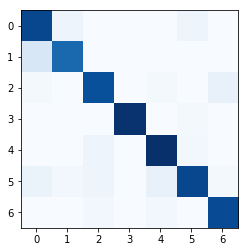

In [ ]:
y_pred3=model3.predict(x_test)
y_pred3= np.argmax(y_pred3, axis=1)

print('Classification report:')
print(classification_report(y_test_eff, y_pred3))

print('Confusion matrix:')
cm=confusion_matrix(y_test_eff, y_pred3)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

The difference between the first and the second model are very low, but with increase of complexity increase accuracy.

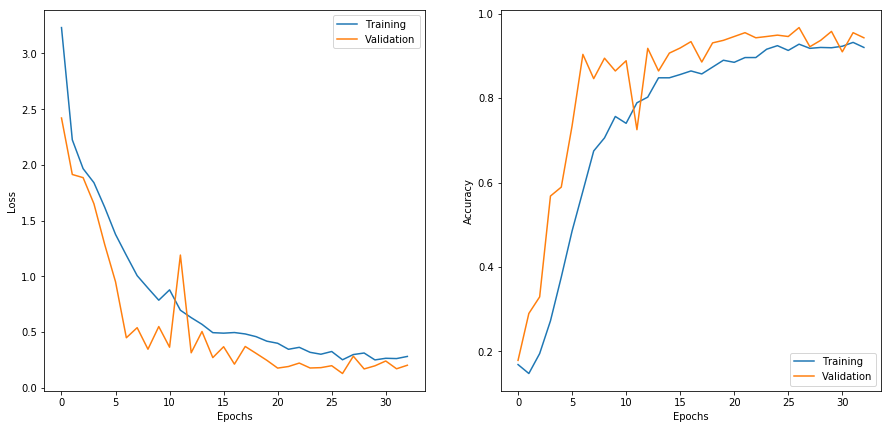

In [ ]:
model_plot(history_vggface3)

We obtain same performance of the first case and maintain the advatanges of the second case (less overfitting). The only problem that remains is the less stability. For this reason, we added a weight regularization.

We choice L1 weight regularization that can add the cost (associated with having large weights) to the loss function and it is proportional to the absolute value of the weight coefficients.
In this case, we choice a parameter of L1 regularization equal to 0.01 that means every coefficients in the weight matrix of the layer will add $0.01 * weight$ to the total loss of the network:

$loss= 0.01 * reduce\_sum(|x|)$

In [ ]:
base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
model4 = Sequential()
model4.add(base_model)
model4.add(Flatten())
model4.add(Dense(512, activation = 'relu', bias_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l1(0.01)))
model4.add(Dropout(.5))
model4.add(Dense(512, activation = 'relu',bias_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l1(0.01)))
model4.add(Dropout(.5))
model4.add(Dense(216, activation = 'relu',bias_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l1(0.01)))
model4.add(Dropout(.5))
model4.add(Dense(7, activation = 'softmax'))

model4.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics = ['acc'])
   

filepath = "C:/Users/valen/Desktop/magistrale/DSIM/aml/weights-tmp4.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early= EarlyStopping(monitor='val_loss', patience= 6, mode='min', verbose=1)
lr_decay=ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

history_vggface4 = model4.fit_generator(train_generator, epochs = 100, validation_data = val_generator,
                              verbose = 1, callbacks = [checkpoint, early, lr_decay], steps_per_epoch=45, validation_steps=11)

Epoch 1/100
45/45 [==============================] - 109s 2s/step - loss: 393.0166 - acc: 0.1646 - val_loss: 375.0984 - val_acc: 0.2205
Epoch 2/100
45/45 [==============================] - 101s 2s/step - loss: 357.0052 - acc: 0.1891 - val_loss: 337.2206 - val_acc: 0.3897
Epoch 3/100
45/45 [==============================] - 102s 2s/step - loss: 318.5620 - acc: 0.2704 - val_loss: 298.6381 - val_acc: 0.4830
Epoch 4/100
45/45 [==============================] - 101s 2s/step - loss: 280.3530 - acc: 0.3884 - val_loss: 260.9344 - val_acc: 0.7221
Epoch 5/100
45/45 [==============================] - 101s 2s/step - loss: 243.5781 - acc: 0.5435 - val_loss: 225.5263 - val_acc: 0.6707
Epoch 6/100
45/45 [==============================] - 101s 2s/step - loss: 209.2573 - acc: 0.6362 - val_loss: 192.3928 - val_acc: 0.7221
Epoch 7/100
45/45 [==============================] - 101s 2s/step - loss: 177.5388 - acc: 0.7384 - val_loss: 162.5208 - val_acc: 0.7039
Epoch 8/100
45/45 [=============================

Epoch 61/100
45/45 [==============================] - 102s 2s/step - loss: 1.4848 - acc: 0.9063 - val_loss: 1.2060 - val_acc: 0.9486
Epoch 62/100
45/45 [==============================] - 103s 2s/step - loss: 1.5718 - acc: 0.8855 - val_loss: 1.2241 - val_acc: 0.9366
Epoch 63/100
45/45 [==============================] - 103s 2s/step - loss: 1.4964 - acc: 0.9155 - val_loss: 1.2349 - val_acc: 0.9261
Epoch 64/100
45/45 [==============================] - 102s 2s/step - loss: 1.4987 - acc: 0.9088 - val_loss: 1.2076 - val_acc: 0.9396

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 65/100
45/45 [==============================] - 103s 2s/step - loss: 1.4473 - acc: 0.9218 - val_loss: 1.2212 - val_acc: 0.9305
Epoch 66/100
45/45 [==============================] - 103s 2s/step - loss: 1.4198 - acc: 0.9294 - val_loss: 1.1588 - val_acc: 0.9426
Epoch 67/100
45/45 [==============================] - 102s 2s/step - loss: 1.4422 - acc: 0.9167 - val_loss: 1.1685 - val_

In [ ]:
model4.load_weights(filepath)
score = model4.evaluate_generator(test_generator, verbose=1, steps=14)
accuracy = 100*score[1]
loss = score[0]
print("Test accuracy: {} %".format(round(accuracy, 3)))
print("Test loss: {}".format(round(loss, 4)))

14/14 [==============================] - 20s 1s/step
Test accuracy: 90.848 %
Test loss: 1.3003


Classification report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        64
           1       0.94      0.78      0.85        60
           2       0.92      0.89      0.90        63
           3       1.00      1.00      1.00        64
           4       0.92      0.94      0.93        69
           5       0.91      0.85      0.88        73
           6       0.89      0.97      0.93        61

    accuracy                           0.91       454
   macro avg       0.91      0.91      0.91       454
weighted avg       0.91      0.91      0.91       454

Confusion matrix:
[[61  2  0  0  0  1  0]
 [ 9 47  1  0  0  3  0]
 [ 1  0 56  0  1  1  4]
 [ 0  0  0 64  0  0  0]
 [ 0  0  1  0 65  1  2]
 [ 2  1  3  0  4 62  1]
 [ 1  0  0  0  1  0 59]]


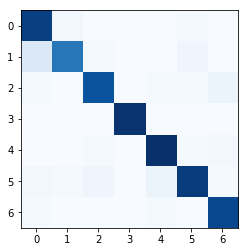

In [ ]:
y_pred4=model4.predict(x_test)
y_pred4= np.argmax(y_pred4, axis=1)

print('Classification report:')
print(classification_report(y_test_eff, y_pred4))

print('Confusion matrix:')
cm=confusion_matrix(y_test_eff, y_pred4)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

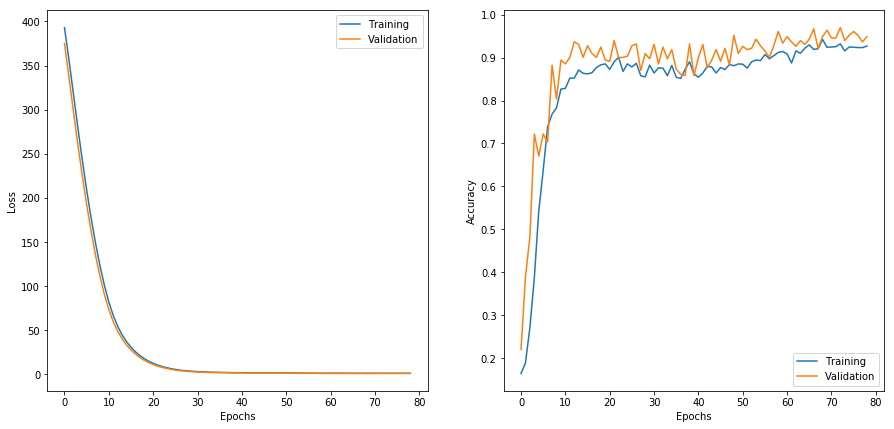

In [ ]:
model_plot(history_vggface4)

The value of accuracy increase. On the other side, we note that values of loss function are very stable (even too much) and values of accuracy are more instable than other case. 